## EB-learner baseline for IHDP
* Entropy-balancing weighting
* Implemented with tensorflow

In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf

import pandas as pd
import math

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
class flags:
    
    x_dim = 25
    y_dim = 1
    t_dim = 2
    M = 30
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    hidden_size = 2
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [3]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
NORM = True
VAL = True

ihdp_id = 0

In [5]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname,end=': ')
    print(x_shape)

def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size, n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [6]:
def simple_mlp(x,out_dim,name):
    
    hidden_units = 64   # size of hidden units in a layer
    
    input_tensor = x
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hidden_units,activation=tf.nn.relu)
        o = tf.layers.dense(h2,out_dim,activation=None)
        
    return o;

def linear_mdl(x,out_dim,name):
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        o = tf.layers.dense(x,out_dim,activation=None)
        
    return o;

In [7]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

In [8]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [9]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

In [10]:
data = np.load('../ihdp_example.npy',allow_pickle=True).item()
X = data['X'] # Confounder proxiess
Y = data['Y'] # Factual outcomes
T = data['T'] # Treatment
Tau = data['Tau']  # Ground truth ITE

n_samples = X.shape[0]

In [12]:
t1_ind = T[:,1]==1   # find which column has the treatment == 1
t0_ind = T[:,0]==1 

n0 = np.sum(t0_ind)
n1 = np.sum(t1_ind)

X0 = X[t0_ind]
X1 = X[t1_ind]

Y0 = Y[t0_ind]
Y1 = Y[t1_ind]

In [13]:
def mu_learner(x,t):
    
    input_tensor = tf.concat([x,tf.cast(t,tf.float32)],axis=-1) 
    
    mu = simple_mlp(input_tensor,FLAGS.y_dim,'mu')
    
    return mu

In [14]:
# train_tau = tf.train.AdamOptimizer(learning_rate).minimize(loss_r, var_list=tau_vars)

### Training

In [15]:
def estimate_causal_effect(xx, e_x_, m_x_, n_runs=1):

    m_samples = xx.shape[0]

    t0 = np.zeros([m_samples,FLAGS.t_dim]); t0[:,0] = 1;
    t1 = np.zeros([m_samples,FLAGS.t_dim]); t1[:,1] = 1;
    mu0_hat = estimate_outcome(xx, t0, e_x_, m_x_, n_runs)
    mu1_hat = estimate_outcome(xx, t1, e_x_, m_x_, n_runs)

    tau_hat = mu1_hat - mu0_hat

    return tau_hat

def estimate_outcome(xx, tt, e_x_, m_x_, n_runs=1):
    m_samples = xx.shape[0]

    y_t_hat = 0

    for i in range(n_runs):

        y_t_hat = tf_eval(y_hat,m_samples,{input_x: xx, input_t: tt, e_x: e_x_, m_x: m_x_})

    y_t_hat /= n_runs

    return y_t_hat

def check_results(x_x,t_x,y_x,e_x_,m_x_,tau_x,msg=''):
    
    tau_hat = estimate_causal_effect(x_x,e_x_,m_x_).reshape([-1,])    
    pehe_mkl = eval_pehe(tau_hat, tau_x)*y_std
    corr_ = np.corrcoef(tau_hat.reshape([-1,]),tau_x.reshape([-1,]))[0,1]
    err_ = np.mean(tau_hat)-4  
    
    Y_mdl = estimate_outcome(x_x,t_x,e_x_,m_x_)
    rmse_ = eval_y_rmse(y_x, Y_mdl)

    
    print('%sPEHE=%.2f, CORR=%.2f, ERR=%.2f, RMSE=%.2f' % (msg, pehe_mkl, corr_, err_, rmse_) )
    
    return [pehe_mkl, corr_, err_, rmse_]

def eval_y_rmse(yy,yy_mdl):
    
    yy_mdl_mean = np.mean(yy_mdl,axis=1).reshape([-1,1])
    
    rmse = np.sqrt(np.mean(np.square(yy-yy_mdl_mean)))
    
    return rmse


In [16]:
# Estimating Entropy balancing weights

x0 = X0
x1 = X1

In [17]:
lam = tf.Variable(0.1*np.random.randn(1,X.shape[1]),dtype=DTYPE)

In [18]:
x0_tf = tf.constant(x0,dtype=DTYPE)
x1_tf = tf.constant(x1,dtype=DTYPE)

In [19]:
x0_lam = tf.multiply(x0_tf,lam) 
x1_bar = tf.reduce_mean(x1_tf,axis=0,keepdims=True) # 1 x dim
x1_bar_lam = tf.matmul(lam, tf.transpose(x1_bar))
omega = tf.reduce_sum(x0_lam,axis=1)
t1 = tf.log(tf.reduce_sum(tf.exp(omega)))
t2 = tf.reshape(x1_bar_lam,[])
loss = t1-t2

w_eb = tf.nn.softmax(omega)

In [20]:
learning_rate = tf.placeholder(tf.float32)

train_lam = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [21]:
# Initialization

initializer = tf.global_variables_initializer()
sess.run(initializer)

[1, 5.988876857757568, 0.0778200626373291]
[2, 5.736371221542359, 0.057366371154785156]
[3, 5.623866720199585, 0.05208897590637207]
[4, 5.566918067932129, 0.053862571716308594]
[5, 5.528247056007385, 0.045320749282836914]
[6, 5.496501359939575, 0.04637002944946289]
[7, 5.46924479007721, 0.06269478797912598]
[8, 5.446005597114563, 0.06023526191711426]
[9, 5.426578330993652, 0.053647756576538086]
[10, 5.41069878578186, 0.05533576011657715]


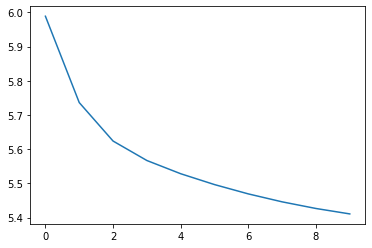

In [22]:
# Training EB weights

lr = 1e-3

max_epoch = 10
updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):
        
        feed_dict = {learning_rate: lr}
        
        _, loss_val = sess.run([train_lam, loss], feed_dict)
        
        loss_record[step] = loss_val
    
    t1 = time()
    
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
_ = plt.plot(epoch_record)


In [23]:
w_eb_val = sess.run(w_eb)

In [24]:
Wx0 = w_eb_val
Wx1 = np.ones([n1,])/n1

#### EB-weights

In [25]:
n = X.shape[0]
Wx = np.zeros([n,])
Wx[t0_ind] = Wx0
Wx[t1_ind] = Wx1
Wx = Wx/2*n

In [26]:
XT = np.concatenate([X,T[:,1].reshape([-1,1])],axis=1)

In [29]:
n_trees = 50
model_m = RandomForestRegressor(n_estimators=n_trees)
model_m.fit(XT,Y.reshape([-1,]),Wx)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
def estimate_causal_effect(model,X):
    
    n = X.shape[0]
    
    t0 = np.zeros([n,1])
    t1 = np.ones([n,1])
    
    Xt0 = np.concatenate([X,t0],axis=1)
    Xt1 = np.concatenate([X,t1],axis=1)
    
    mu0_hat = model.predict(Xt0)
    mu1_hat = model.predict(Xt1)
    
    tau_hat = mu1_hat - mu0_hat
    
    return tau_hat

In [31]:
# np.zeros([2,1])

tau_hat = estimate_causal_effect(model_m, X)

In [34]:
pehe_mkl = eval_pehe(tau_hat, Tau)#*y_std

print(pehe_mkl)

0.8783947819727507


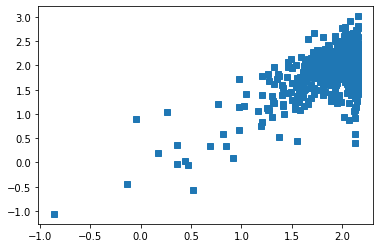

In [33]:
_ = plt.plot(Tau,tau_hat,'s')